# Learning Deep Learning 01: Shallow Learning (mostly)


In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Linear Regression

- Weights

https://www.tylervigen.com/spurious-correlations
- No. people died becoming tangled in bed sheets
- Per capita cheese consumption
- Civil engineering doctorates awarded

In [2]:
df = pd.read_csv("cheese_sheets.csv")
df

,sheets,cheese,doctorates
0,327,29.8,480
1,456,30.1,501
2,509,30.5,540
3,497,30.6,552
4,596,31.3,547
5,573,31.7,622
6,661,32.6,655
7,741,33.1,701
8,809,32.7,712
9,717,32.8,708


Text(0.5, 0, 'Awarded civil engineering doctorates')

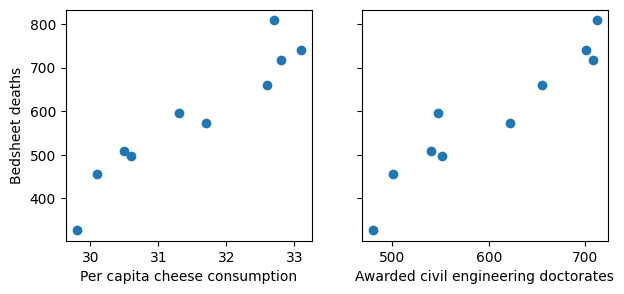

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax[0].scatter(df["cheese"], df["sheets"])
ax[0].set_ylabel("Bedsheet deaths")
ax[0].set_xlabel("Per capita cheese consumption")
ax[1].scatter(df["doctorates"], df["sheets"])
ax[1].set_xlabel("Awarded civil engineering doctorates")


$$
\hat{y} = w_1 x_1 + w_2 x_2 + b
$$

where:
- $\hat{y}$ : Predicted number of deaths by tangling in bedsheets
- $x_1$ : Per capita cheese consumption
  - $w_1$ : Number of deaths per lb cheese consumed
- $x_2$ : Awarded Civil Engineering doctorates
  - $w_2$ : Number of deaths per doctorate awarded
- $b$ : Intercept (number of deaths if no cheese consumed and no doctorates awarded)


Learn "best" values of $w_1$, $w_2$, and $b$
- how?

## Loss Function

Choose $w_1$, $w_2$, $b$ to minimise the mean squared error between the predicted and actual value:

$$
L = \frac{1}{2N} \sum_{i=1}^{N} (\hat{y_i} - y_i)^2
$$

(divided by 2 to tidy up some maths later)

Here's an example for one choice of $w_1$, $w_2$ and $b$. The loss is the sum of the lengths of the vertical black lines (squared) - the difference between the predicted and actual value:

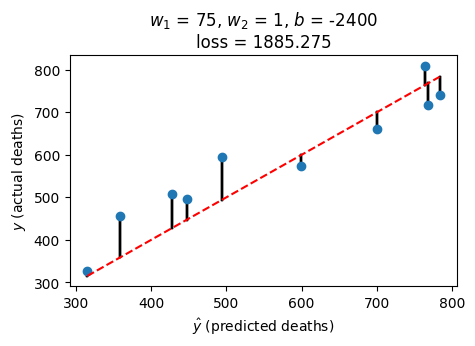

In [4]:
# [62.71436266  0.71814293], -1820.3351250841451

def predict(X, w_1, w_2, b):
    return w_1 * X["cheese"] + w_2 * X["doctorates"] + b


def loss(y_hat, y):
    return ((y_hat - y)**2).sum() / (2 * len(y))



def plot_predictions(w_1, w_2, b, ax=None):
    y_hat = predict(df[["cheese", "doctorates"]], w_1, w_2, b)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(y_hat, df["sheets"], "o")
    ax.plot([y_hat.min(), y_hat.max()], [y_hat.min(), y_hat.max()], "r--")
    ax.set_xlabel(r"$\hat{y}$ (predicted deaths)")
    ax.set_ylabel(r"$y$ (actual deaths)")
    ax.set_title(f"$w_1$ = {w_1}, $w_2$ = {w_2}, $b$ = {b}\nloss = {loss(y_hat, df['sheets']):.3f}")
    for _, row in df.iterrows():
        ax.plot([y_hat, y_hat], [y_hat, df["sheets"]], "k", zorder=0)


plot_predictions(75, 1, -2400)

We can compute the loss for many different values of $w_1$, $w_2$, and $b$ (here varying only one or two of the parameters due to be able to plot nicely):

In [5]:
def plot_loss_grid_2d(ax, title=""):
    samples = 20
    W_1 = np.linspace(50, 70, samples)
    W_2 = np.linspace(0.55, 1.0, samples)
    b = -1820.3351250841451

    w1_plot = []
    w2_plot = []
    losses = []
    for w_1, w_2 in itertools.product(W_1, W_2):
        w1_plot.append(w_1)
        w2_plot.append(w_2)
        losses.append(loss(predict(df, w_1, w_2, b), df["sheets"]))

    sns.heatmap(
        np.array(losses).reshape(samples, samples),
        xticklabels=W_1.round(2),
        yticklabels=W_2.round(2),
        cbar_kws={"label": "Loss"},
        ax=ax,
    )
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")
    ax.set_title(title)


def plot_loss_grid_1d(ax, title=""):
    samples = 50
    W_1 = np.linspace(50, 75, samples)
    w_2 = 0.71814293
    b = -1820.3351250841451

    w1_plot = []
    losses = []
    for w_1 in W_1:
        w1_plot.append(w_1)
        losses.append(loss(predict(df, w_1, w_2, b), df["sheets"]))

    ax.plot(w1_plot, losses)
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("loss")
    ax.set_title(title)


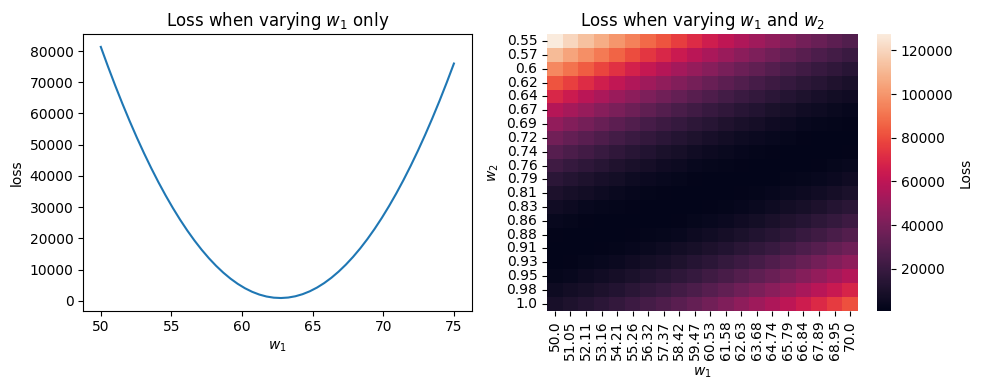

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_loss_grid_1d(ax[0], title="Loss when varying $w_1$ only")
plot_loss_grid_2d(ax[1], title="Loss when varying $w_1$ and $w_2$")
fig.tight_layout()

The best choice of $w_1$, $w_2$, and $b$ is the one that minimises the loss (the bottom of the valleys above) - how to find where that is?

## Gradient Descent

The loss function again (expanded to include the definition of $\hat{y}$):

$$
L = \frac{1}{2N} \sum_{i=1}^{N} (\hat{y_i} - y_i)^2 = \frac{1}{2N} \sum_{i=1}^{N} (w_1 x_{1,i} + w_2 x_{2,i} + b - y)^2
$$

The minimum loss will be found where the partial derivatives of the loss function with respect to the parameters is zero:

$$
\frac{\partial L}{\partial w_1} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i) x_{1,i} \\
\frac{\partial L}{\partial w_2} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i) x_{1,i} \\
\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y_i} - y_i)
$$

Above I've replaced $N$, the number of samples in the dataset, with $m \leq N$, to indicate that we could choose to update the parameters based on the loss of a subset of the data.

$m$ is known as the **batch size**

Different values of $m$ correspond to different forms of gradient descent:

- $m = N$ : Batch Gradient Descent (or just Gradient Descent)
- $m < N$ : Mini Batch Gradient Descent (or Mini Batch Stochastic Gradient Descent)
- $m = 1$: Stochastic Gradient Descent

The random (stochastic) nature of mini batch and stochastic gradient descent come from needing to select a sample of the dataset for each parameter update.

Broadly:
- Batch gradient descent: Slower, better convergence
- (Mini batch) stochastic gradient descent: Faster, worse convergence

We can pick some initial values for $w_1$, $w_2$, and $b$, and then iteratively update them towards the values that will zero the partial derivatives:

$$
w_1 = w_1 - \alpha \frac{\partial L}{\partial w_1} \\
w_2 = w_2 - \alpha\frac{\partial L}{\partial w_2} \\
b = b - \alpha\frac{\partial L}{\partial b}
$$

where $\alpha$ is the "learning rate" (or the relative size of the parameter updates we're going to make after each iteration)

The learning rate is a hyperparameter:
- $\alpha$ too large - gradient descent may not converge
- $\alpha$ too small - gradient descent will take too long to converge

Gradient descent will converge faster if all the features are on the same scale, so we can standardise them (to have mean zero and standard deviation of one):

In [7]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

df.describe()

,sheets,cheese,doctorates
count,1.000000e+01,1.000000e+01,1.000000e+01
mean,-1.776357e-16,8.659740e-16,4.884981e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.779174e+00,-1.397353e+00,-1.373261e+00
25%,-6.025795e-01,-8.083526e-01,-6.770471e-01
50%,-2.788460e-02,-1.624829e-02,-1.668659e-01
75%,7.780485e-01,9.383389e-01,9.887931e-01
max,1.498968e+00,1.283615e+00,1.242474e+00


Here's a basic implementation of batch gradient descent:

In [8]:
def gradient_descent(df, learning_rate=0.001, epochs=1000):
    w_1 = 0
    w_2 = 0
    b = 0
    X = df[["cheese", "doctorates"]]
    y = df["sheets"]
    losses = []
    for e in range(epochs):
        l = loss(predict(df[["cheese", "doctorates"]], w_1, w_2, b), df["sheets"])
        losses.append(l)

        y_hat = predict(X, w_1, w_2, b)
        delta = y_hat - y
        w_1 = w_1 - (learning_rate / len(y)) * (delta * X["cheese"]).sum()
        w_2 = w_2 - (learning_rate / len(y)) * (delta * X["doctorates"]).sum()
        b = b - (learning_rate / len(y)) * delta.sum()

    return w_1, w_2, b, losses

The number of **epochs** is how many times we'll loop through the entire dataset before stopping (updating the parameters after each _batch_, though in this case we only have one batch per epoch - the entire dataset).

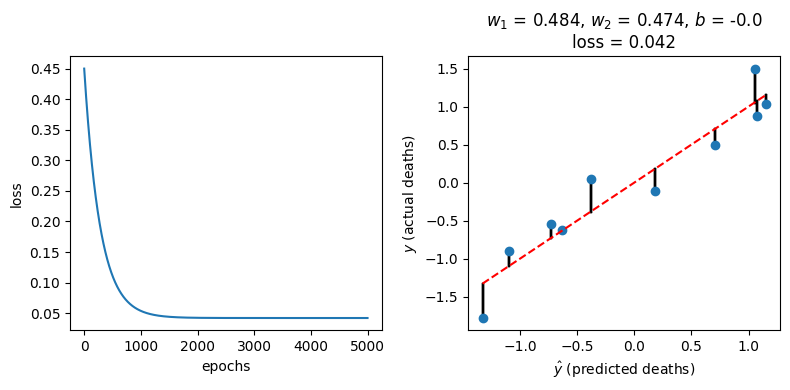

In [9]:
w_1, w_2, b, l = gradient_descent(df, learning_rate=0.001, epochs=5000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(l)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
plot_predictions(round(w_1, 3), round(w_2, 3), round(b, 3), ax[1])
fig.tight_layout()


## Neural Network for Linear Regression

![](linear_regression_net.png)

**Dense** layer: All nodes in the previous layer are connected to all the nodes in the next layer

## Pytorch

- Epoch
- Batch
- (activation - skip over)
- (optimiser - skip over)

## Adding nodes and layers

- still linear activation, what types of function can a network with these learn (still linear regression):
  - 2 nodes, one layer
  - 2 layers, each one node
- hidden layers
- so why all the fuss about neural networks?

## Logistic Regression

- why need different function for classification?
- sigmoid

## Neural Network for Logistic Regression

- activation function

## Pytorch

## Adding nodes and layers

- types of functions with multiple nodes, layers (not just logistic regression anymore?)

## ReLU

- why? briefly, gradients


## Learning Arbitrary Functions - Intuition

- intuition around how this works/allows different non-linear functions to be learned (nodes turning on/off at different values...)